In [18]:
import numpy as np
import sklearn
import torch
import torchvision
from torchvision import transforms
from torch.utils.data import DataLoader, random_split
from sklearn.model_selection import train_test_split
from torchvision.datasets import ImageFolder
import matplotlib.pyplot as plt

In [19]:
data_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))  # Any Reason for this?
])

data=ImageFolder("./archive/Dataset/", transform=data_transform)

In [20]:
# c0=0    # mild
# c1=0    # moderate
# c2=0    # non
# c3=0    # very mild
# for i,d in enumerate(data):
#     if data[i][1]==0:   c0+=1
#     elif data[i][1]==1: c1+=1
#     elif data[i][1]==2: c2+=1
#     elif data[i][1]==3: c3+=1
# print(c0,c1,c2,c3)

In [21]:
n=len(data)
n_test=int(0.2*n)   # 20% for test
train_data,test_data=random_split(data,[n-n_test,n_test],torch.Generator().manual_seed(42))

In [22]:
# c0=0    # mild
# c1=0    # moderate
# c2=0    # non
# c3=0    # very mild
# for i,d in enumerate(test_data):
#     if test_data[i][1]==0:   c0+=1
#     elif test_data[i][1]==1: c1+=1
#     elif test_data[i][1]==2: c2+=1
#     elif test_data[i][1]==3: c3+=1
# print(c0,c1,c2,c3)

In [23]:
trainloader=DataLoader(train_data,batch_size=128,drop_last=False,shuffle=True)
testloader=DataLoader(test_data,batch_size=128,drop_last=False,shuffle=False)

In [24]:
# for i,data in enumerate(trainloader):
#     imgs, targets=data
#     if i<10: print(imgs.shape)
#     else: break

In [25]:
# from PIL import Image
# fig=Image.open("./archive/Dataset/Mild_Demented/mild.jpg")
# plt.imshow(fig)
# print(fig)

In [26]:
import torch.nn.functional as F

class ConvNet(torch.nn.Module):
    def __init__(self):
        super(ConvNet, self).__init__()
        # Set for convolution operation
        self.conv1 = torch.nn.Sequential(
            torch.nn.Conv2d(3, 16, 3, padding=1), 
            torch.nn.ReLU(), 
            torch.nn.MaxPool2d(2, 2)
        )
        self.conv2 = torch.nn.Sequential(
            torch.nn.Conv2d(16, 32, 3, padding=1),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(2, 2)
        )
        self.conv3 = torch.nn.Sequential(
            torch.nn.Conv2d(32, 64, 3, padding=1),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(2, 2)
        )

        self.conv4 = torch.nn.Sequential(
            torch.nn.Conv2d(64, 128, 3, padding=1),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(2, 2)
        )

        self.dp = torch.nn.Dropout(p=0.5)

        self.fc1 = torch.nn.Sequential(
            torch.nn.Linear(128*8*8, 32),
            torch.nn.ReLU()
        )
        self.fc2 = torch.nn.Linear(32, 4)
        
    def forward(self, x):
        # Three-layer convolutional network (Conv -> ReLU -> MaxPool)
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.conv4(x)
        x = self.dp(x)
        x = x.view(-1, 128*8*8)
        x = self.fc1(x) # Fully connected layer -> ReLU
        x = self.fc2(x) 
        out = F.log_softmax(x, dim=1) # Softmax probability
        return out

net_cpu = ConvNet()
net_gpu = net_cpu.cuda()

In [27]:
from torch import optim
from torch.utils.tensorboard import SummaryWriter

summaryWriter = SummaryWriter("logs/lyf_cnn_3")

optimizer = optim.Adam(
    net_gpu.parameters(),
    lr = 0.001,
    betas = (0.9, 0.999),
    eps = 1e-08,
    weight_decay = 0,
    amsgrad = False
)

loss_func = torch.nn.CrossEntropyLoss()

for epoch in range(50):
    running_loss_train = 0
    for i, data in enumerate(trainloader, 0):
        inputs_cpu, targets_cpu = data
        inputs_gpu = inputs_cpu.cuda()
        targets_gpu = targets_cpu.cuda()
        optimizer.zero_grad()
        outputs_gpu = net_gpu.train()(inputs_gpu)
        loss = loss_func(outputs_gpu, targets_gpu)
        running_loss_train += loss.item()
        loss.backward()
        optimizer.step()
        if i % 8 == 7:
            print('Train Epoch: %d [%d/5000] Loss: %.6f' %(epoch, i*64, loss.item()))
    running_loss_train /= len(trainloader)
    print(running_loss_train)
    summaryWriter.add_scalar("loss", running_loss_train, epoch)

    # Step 4 Predict
    correct = 0
    total = 0
    running_loss = 0
    for data in testloader:
        images_cpu, targets_cpu = data
        images_gpu = images_cpu.cuda()
        targets_gpu = targets_cpu.cuda()
        outputs_gpu = net_gpu.eval()(images_gpu)
        _, predicted = torch.max(outputs_gpu, 1)
        loss = loss_func(outputs_gpu, targets_gpu)
        total += targets_gpu.size(0)
        running_loss += loss.item()
        correct += (predicted == targets_gpu).sum().item()
    
    running_loss = running_loss / 10000

    print('Test set: Average loss: %.4f, Accuracy: %d/10000 (%d%%)' %(running_loss, correct, correct*100/total))
    summaryWriter.add_scalar("accuracy", correct/total, epoch)

print('Train and predict complete!')    

Train Epoch: 0 [448/5000] Loss: 1.234264
Train Epoch: 0 [960/5000] Loss: 1.192123
Train Epoch: 0 [1472/5000] Loss: 1.028847
Train Epoch: 0 [1984/5000] Loss: 1.158864
Train Epoch: 0 [2496/5000] Loss: 0.968348
1.176887346804142
Test set: Average loss: 0.0010, Accuracy: 651/10000 (50%)
Train Epoch: 1 [448/5000] Loss: 1.055168
Train Epoch: 1 [960/5000] Loss: 0.980253
Train Epoch: 1 [1472/5000] Loss: 0.993573
Train Epoch: 1 [1984/5000] Loss: 1.018553
Train Epoch: 1 [2496/5000] Loss: 0.973411
1.0067195862531662
Test set: Average loss: 0.0010, Accuracy: 656/10000 (51%)
Train Epoch: 2 [448/5000] Loss: 0.977366
Train Epoch: 2 [960/5000] Loss: 1.022532
Train Epoch: 2 [1472/5000] Loss: 0.884617
Train Epoch: 2 [1984/5000] Loss: 1.027266
Train Epoch: 2 [2496/5000] Loss: 0.961592
0.9522234946489334
Test set: Average loss: 0.0009, Accuracy: 702/10000 (54%)
Train Epoch: 3 [448/5000] Loss: 0.939151
Train Epoch: 3 [960/5000] Loss: 0.932697
Train Epoch: 3 [1472/5000] Loss: 0.946233
Train Epoch: 3 [1984/5

EX1: Conv2D-Conv2D-Conv2D-MaxPooling-Flatten-Dense 98.05%
EX2: Conv2D-MaxPooling-Conv2D-MaxPooling-Conv2D-MaxPooling-Flatten-Dense 92%
EX3: Conv2D-MaxPooling-Conv2D-MaxPooling-DropOut-Conv2D-MaxPooling-DropOut-Flatten-Dense-Dense-Dense 99%


In [28]:
all_preds=[]
all_labels=[]

for i,data in enumerate(testloader):
    imgs,labels=data
    imgs_gpu=imgs.cuda()
    labels_gpu=labels.cuda()
    all_labels=np.append(all_labels,labels_gpu.cpu().numpy())

    output=net_gpu(imgs_gpu)
    _, preds = torch.max(output, 1)
    all_preds=np.append(all_preds,preds.tolist())

print(all_preds[:10])
print(all_labels[:10])

[2. 2. 3. 3. 2. 2. 0. 3. 2. 3.]
[2. 2. 3. 3. 2. 2. 0. 3. 2. 3.]


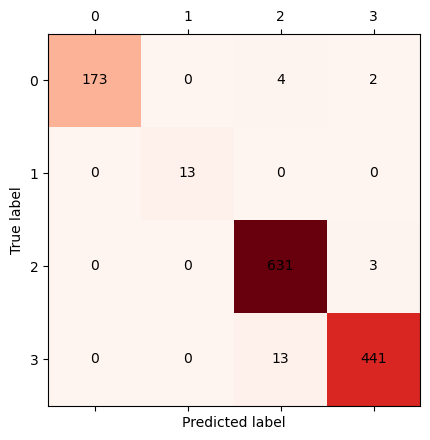

In [29]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt

y_pred = all_preds 
y_true = all_labels

C = confusion_matrix(y_true, y_pred, labels=[0,1,2,3]) 
plt.matshow(C, cmap=plt.cm.Reds)

for i in range(len(C)):
    for j in range(len(C)):
        plt.annotate(C[j, i], xy=(i, j), horizontalalignment='center', verticalalignment='center')

plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()


In [30]:
from sklearn.metrics import precision_score,recall_score,f1_score
precision = precision_score(all_labels,all_preds,average='weighted')
recall = recall_score(all_labels,all_preds,average='weighted')
f1 = f1_score(all_labels,all_preds,average='weighted')
print(precision,recall,f1)

0.9830293733218458 0.9828125 0.9827953656285455
